

# `ibis`: mutate and more aggregates

### Learning Goals

- use `group_by()` and `aggregate()` patterns to summarize data
- use `mutate()` to create an new column that is a function of data from existing columns in a table.


In [8]:
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so 

con = ibis.duckdb.connect()

In [3]:
base_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/"
stock = con.read_csv(base_url + "stock.csv", nullstr="NA")
timeseries = con.read_csv(base_url + "timeseries.csv", nullstr="NA")

Last time we reached the conclusion that we wanted to average across multiple assessments:

In [71]:
cod_stocks = (
  timeseries
  .join(stock, "stockid")
  .filter(_.tsid == "TCbest-MT")
  .filter(_.commonname == "Atlantic cod")
  .group_by(_.tsyear, _.stockid, _.primary_country, _.primary_FAOarea)
  .agg(catch = _.tsvalue.mean())
)


In [70]:
cod_stocks

r0 := DatabaseTable: ibis_read_csv_oqvhqgdgtvffpdkwj2e2hhgkmi
  assessid  string
  stockid   string
  stocklong string
  tsid      string
  tsyear    int64
  tsvalue   float64

r1 := DatabaseTable: ibis_read_csv_jvtzdli36jbcdkhuwkurh7rv7y
  stockid         string
  tsn             int64
  scientificname  string
  commonname      string
  areaid          string
  stocklong       string
  region          string
  primary_country string
  primary_FAOarea int64
  ISO3_code       string
  GRSF_uuid       string
  GRSF_areaid     string
  inmyersdb       int64
  myersstockid    string
  state           string

r2 := JoinChain[r0]
  JoinLink[inner, r1]
    r0.stockid == r1.stockid
  values:
    assessid:        r0.assessid
    stockid:         r0.stockid
    stocklong:       r0.stocklong
    tsid:            r0.tsid
    tsyear:          r0.tsyear
    tsvalue:         r0.tsvalue
    tsn:             r1.tsn
    scientificname:  r1.scientificname
    commonname:      r1.commonname
    areaid:          r1.areaid
    stocklong_right: r1.stocklong
    region:          r1.region
    primary_country: r1.primary_country
    primary_FAOarea: r1.primary_FAOarea
    ISO3_code:       r1.ISO3_code
    GRSF_uuid:       r1.GRSF_uuid
    GRSF_areaid:     r1.GRSF_areaid
    inmyersdb:       r1.inmyersdb
    myersstockid:    r1.myersstockid
    state:           r1.state

r3 := Filter[r2]
  r2.tsid == 'TCbest-MT'

r4 := Filter[r3]
  r3.commonname == 'Atlantic cod'

Aggregate[r4]
  groups:
    tsyear:          r4.tsyear
    stockid:         r4.stockid
    primary_country: r4.primary_country
  metrics:
    catch: Mean(r4.tsvalue)

This is great, but we have a lot of individual cod stocks:  

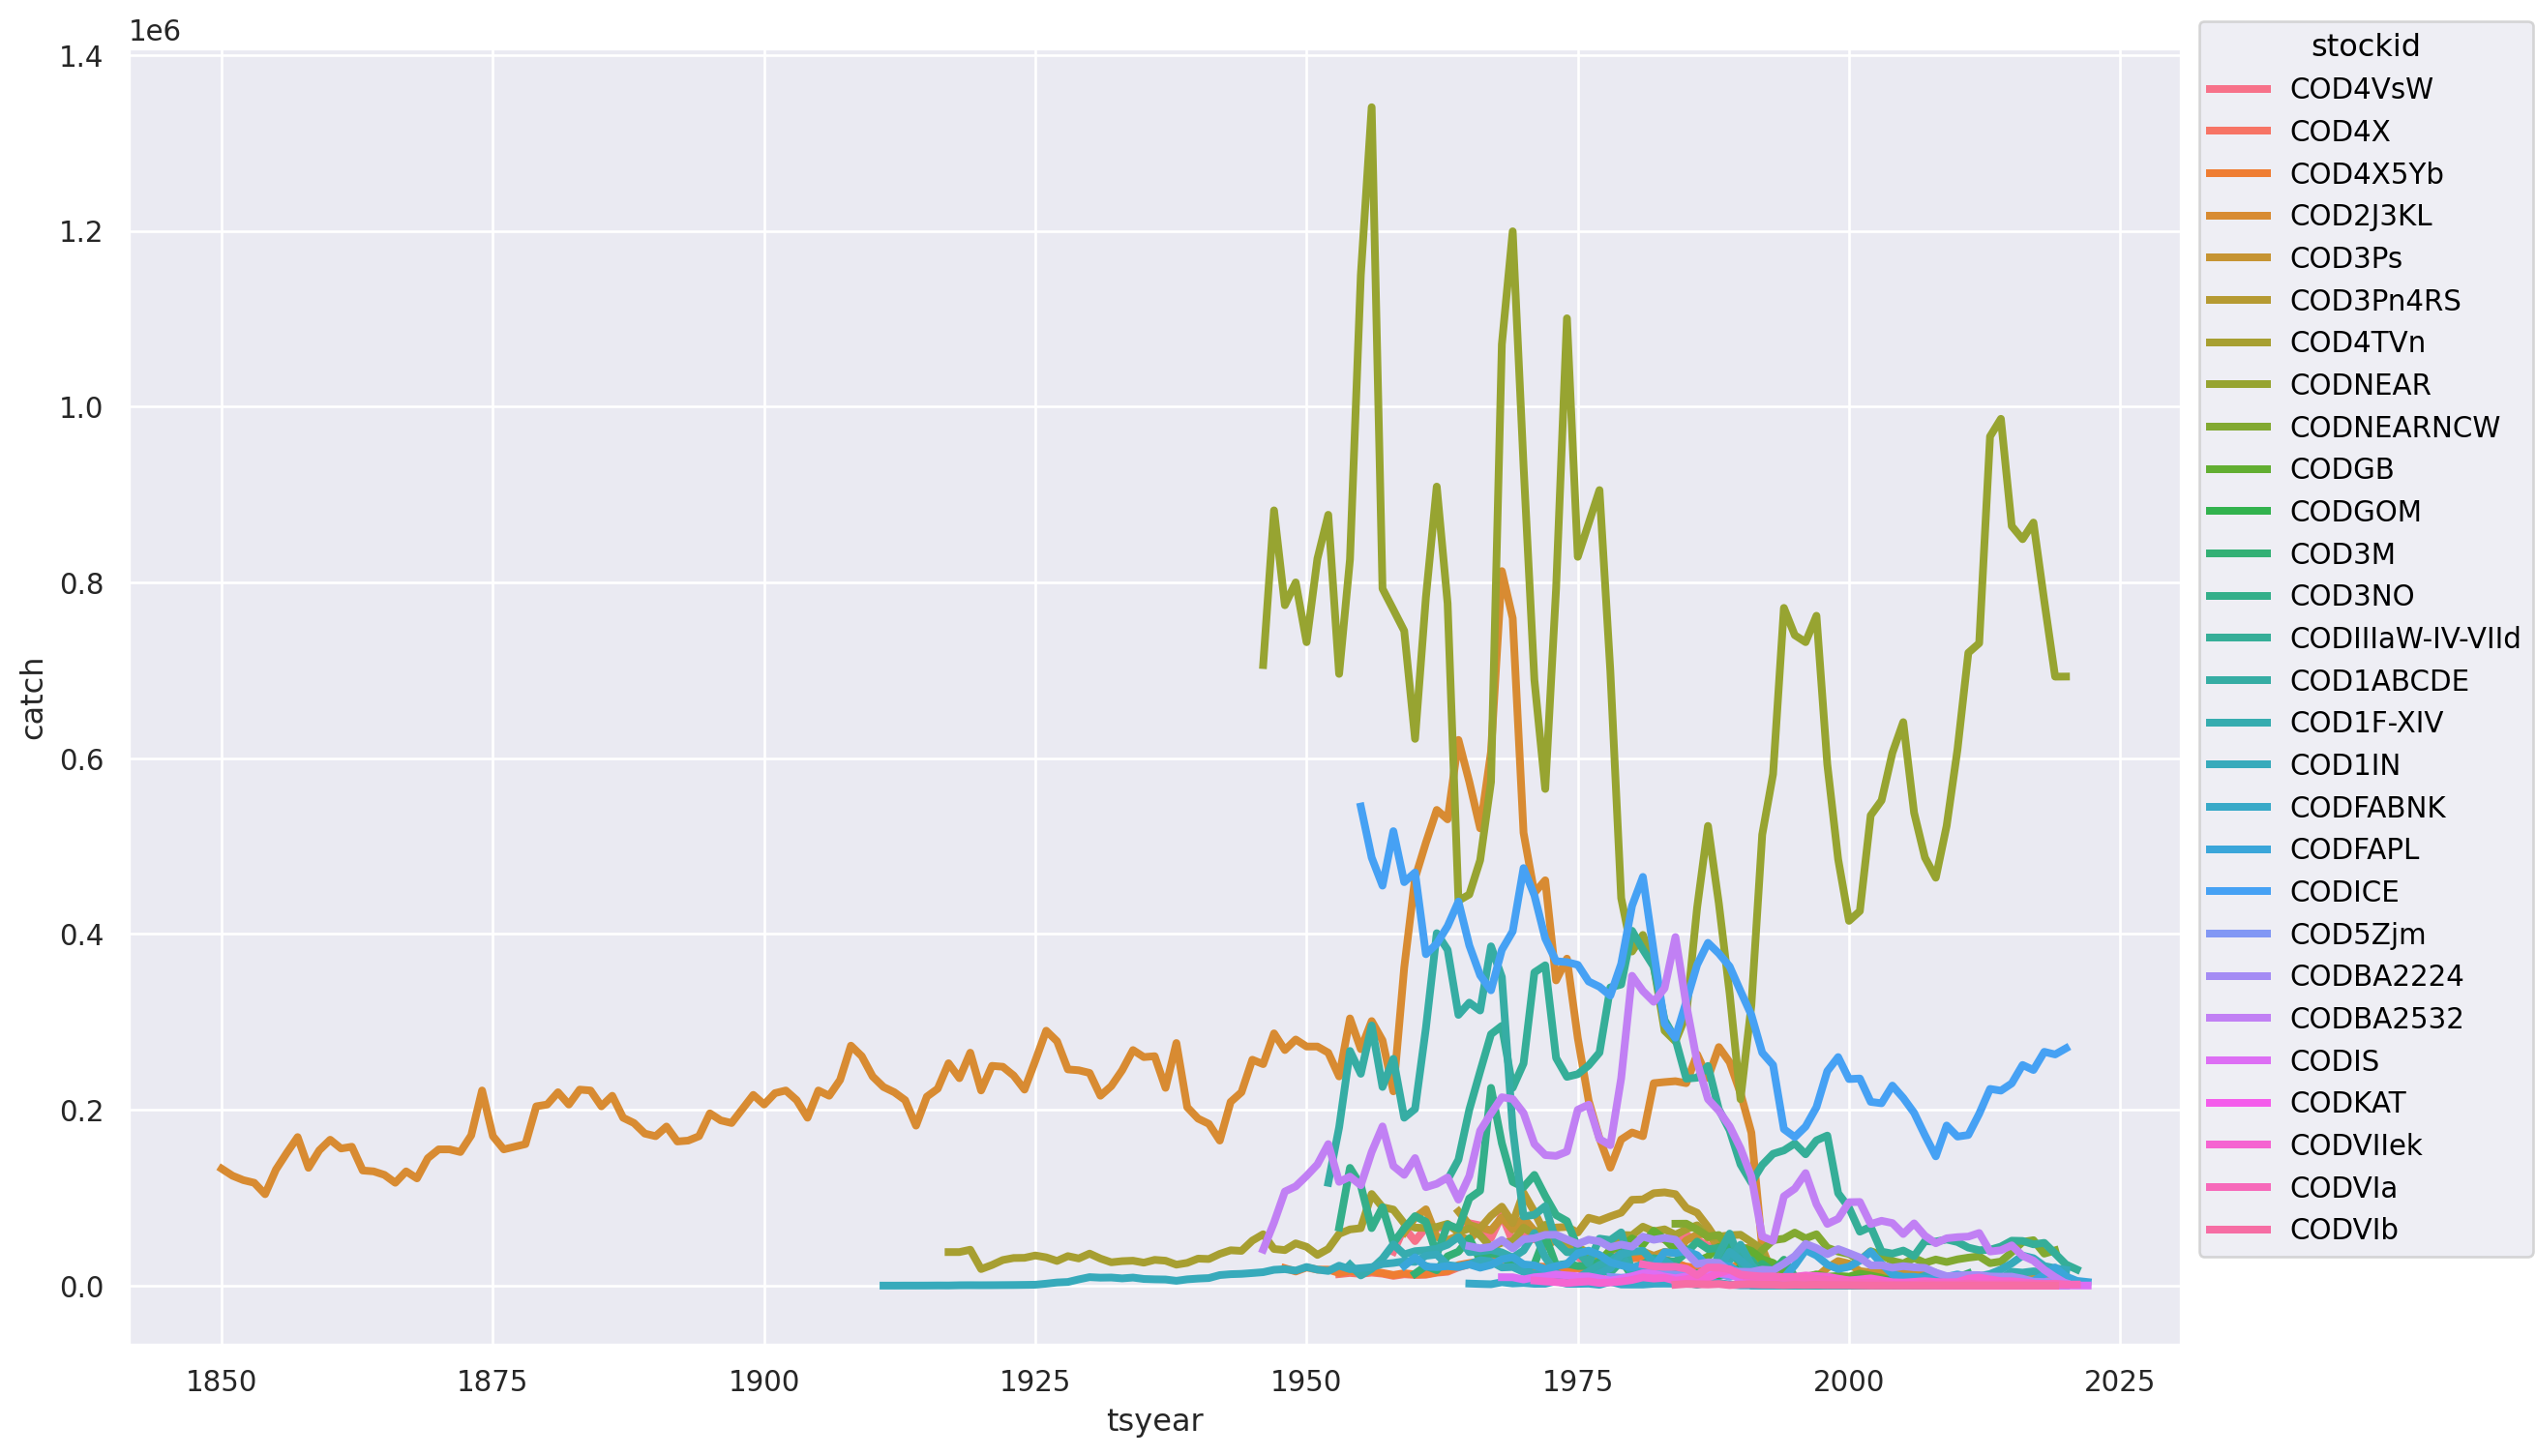

In [72]:
(
    so.Plot(cod_stocks, 
        x = "tsyear",
            y="catch",
            color = "stockid")
    .add(so.Lines(linewidth=3))
    .layout(size=(12, 8))
)

Our good friend, the `COD2J3KL` series shows up with it's remarkable declines, but what's going on with those highly variable but very large catches?  This will obviously impact our assessment of whether or not the species as a whole has collapsed.  This is too many stocks to easily explore, let's try breakint this out by at the by country:

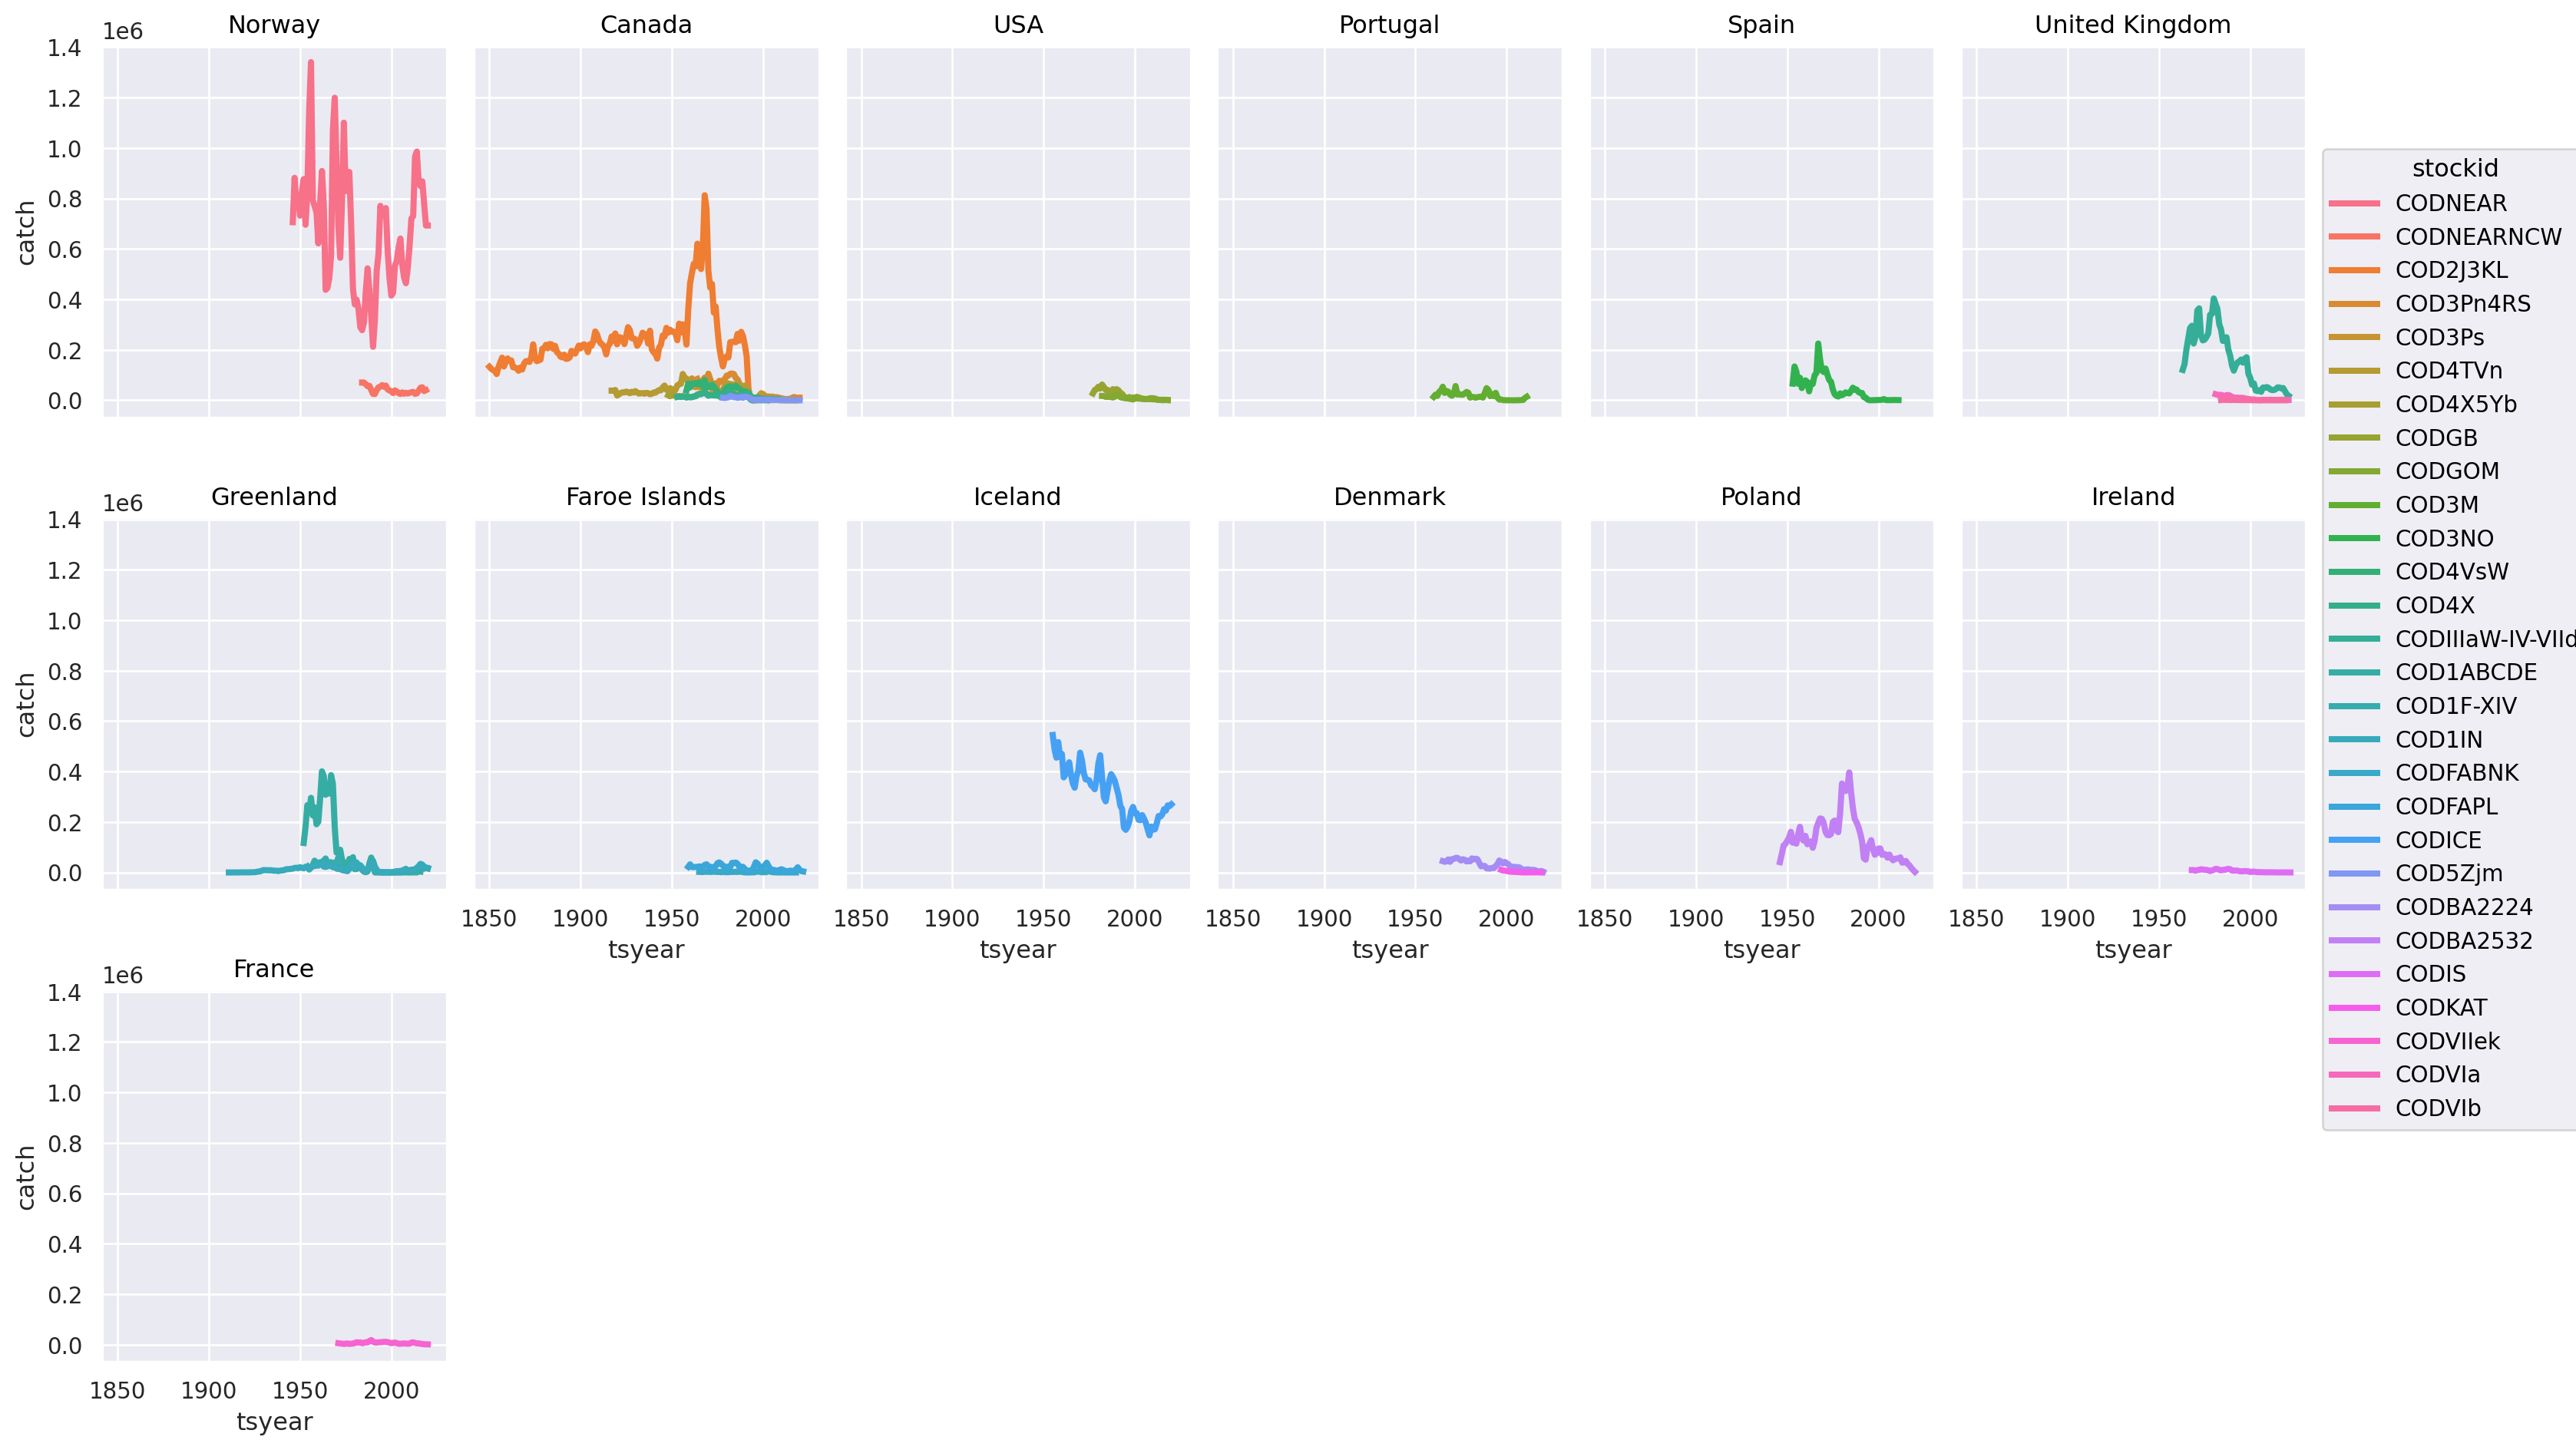

In [69]:
(
    so.Plot(cod_stocks, 
            x = "tsyear", 
            y="catch", 
            color = "stockid",
            group = "primary_country")
    .add(so.Lines(linewidth=3))
    .facet("primary_country", wrap = 6)
    .layout(size=(16, 10))
)

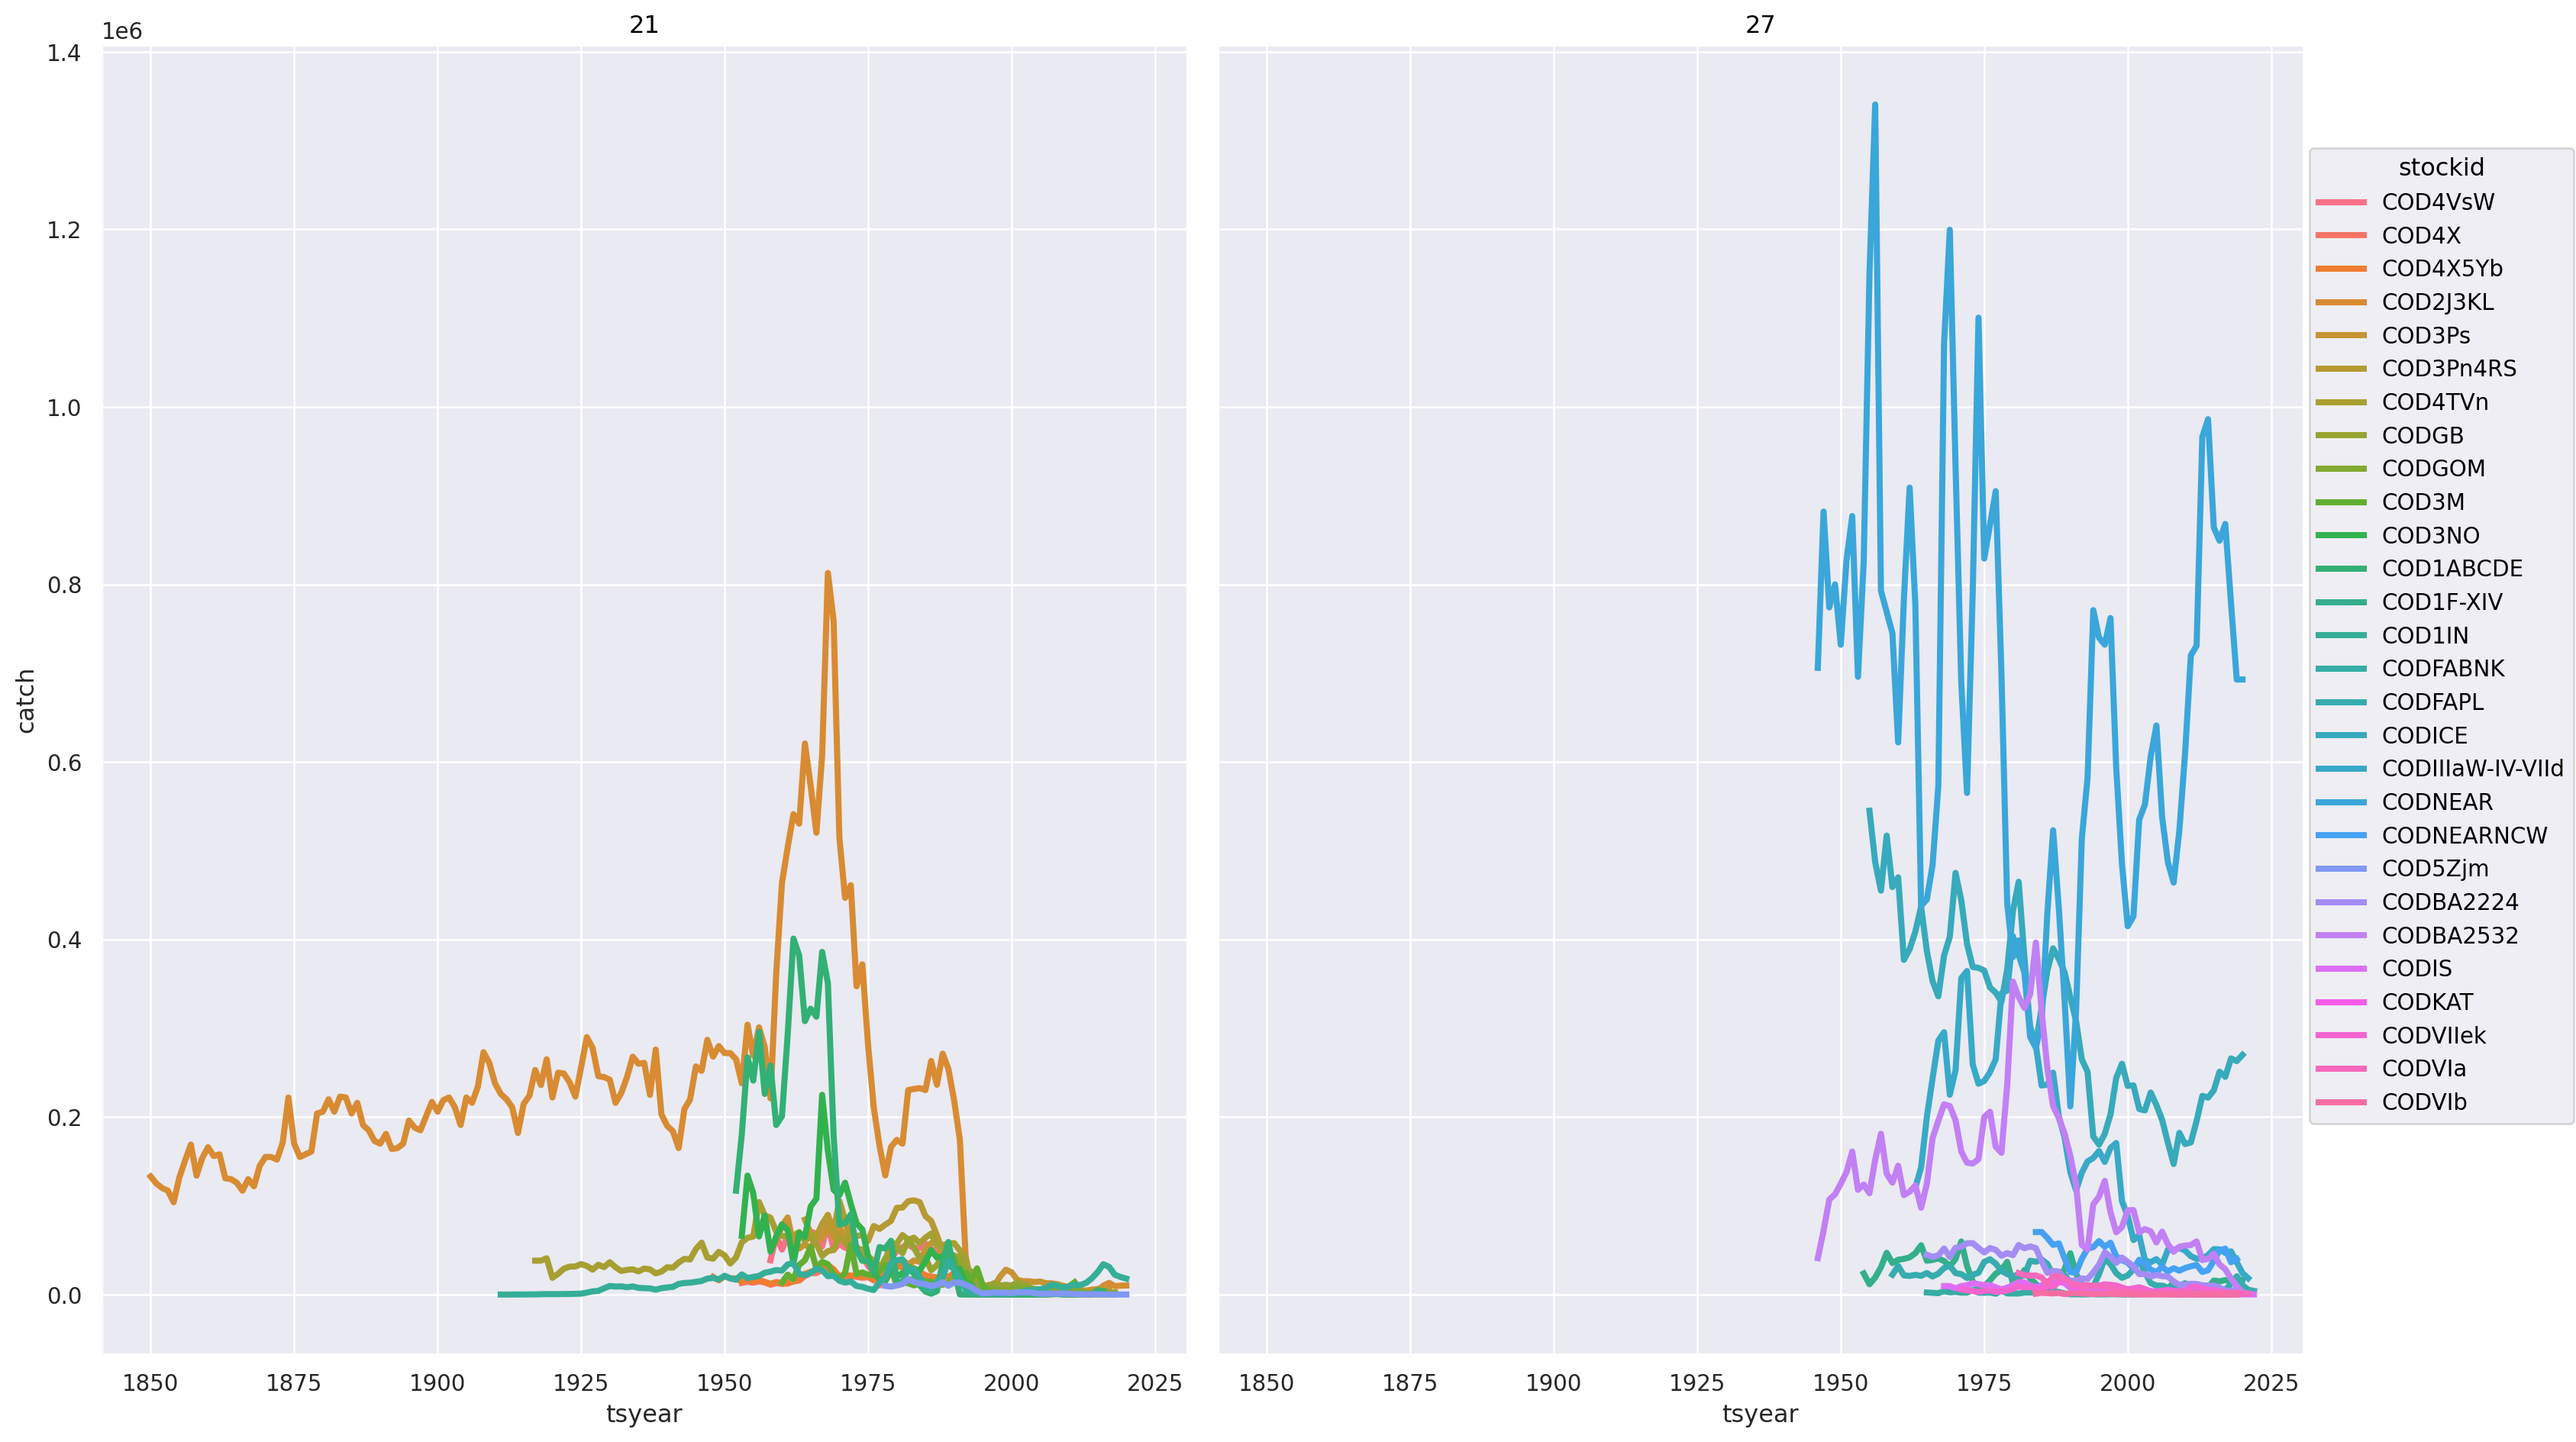

In [73]:
(
    so.Plot(cod_stocks, 
            x = "tsyear", 
            y="catch", 
            color = "stockid",
            group = "primary_FAOarea")
    .add(so.Lines(linewidth=3))
    .facet("primary_FAOarea", wrap = 6)
    .layout(size=(16, 10))
)

In [ ]:
cod_stocks